In [7]:
import os
import tensorflow as tf

from tensorflow import keras

from functions.loading_data import SMALLER_HEIGHT, SMALLER_WIDTH
from functions.plotting import plot_history
from functions.loading_data import load_and_preprocess_data

In [2]:
base_data_dir = os.path.join('..', '..', 'data', 'images_original_inception_resnet_v2_200x150_categorized')
train_data_dir = os.path.join(base_data_dir, 'training')
valid_data_dir = os.path.join(base_data_dir, 'validation')

train_ds = keras.utils.image_dataset_from_directory(
    directory=train_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(SMALLER_HEIGHT, SMALLER_WIDTH))
valid_ds = keras.utils.image_dataset_from_directory(
    directory=valid_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(SMALLER_HEIGHT, SMALLER_WIDTH))

Found 8015 files belonging to 7 classes.
Found 2000 files belonging to 7 classes.


In [3]:
data_augmentation = keras.Sequential([
    keras.layers.Rescaling(1./255),
    keras.layers.RandomFlip('horizontal_and_vertical'),
    keras.layers.RandomRotation(1),
    keras.layers.RandomBrightness((-.5, .5)),
    keras.layers.RandomContrast(.5)
])
train_ds = train_ds\
    .cache()\
    .shuffle(1000)\
    .map(lambda x, y: (data_augmentation(x), y))\
    .prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds\
    .cache()\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

The below is kind of a random choice, something I tend to start my experiments with when I'm doing image recognition. For this task it puts the bar very low.

In [4]:
num_classes = 7


def get_simplest_model() -> keras.Model:
    model = keras.Sequential([
        keras.layers.Rescaling(1./255, input_shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3)),
        keras.layers.Conv2D(32, 5, activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64, 3, activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(128, 3, activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
model = get_simplest_model()
history1 = model.fit(train_ds, validation_data=valid_ds, epochs=50)

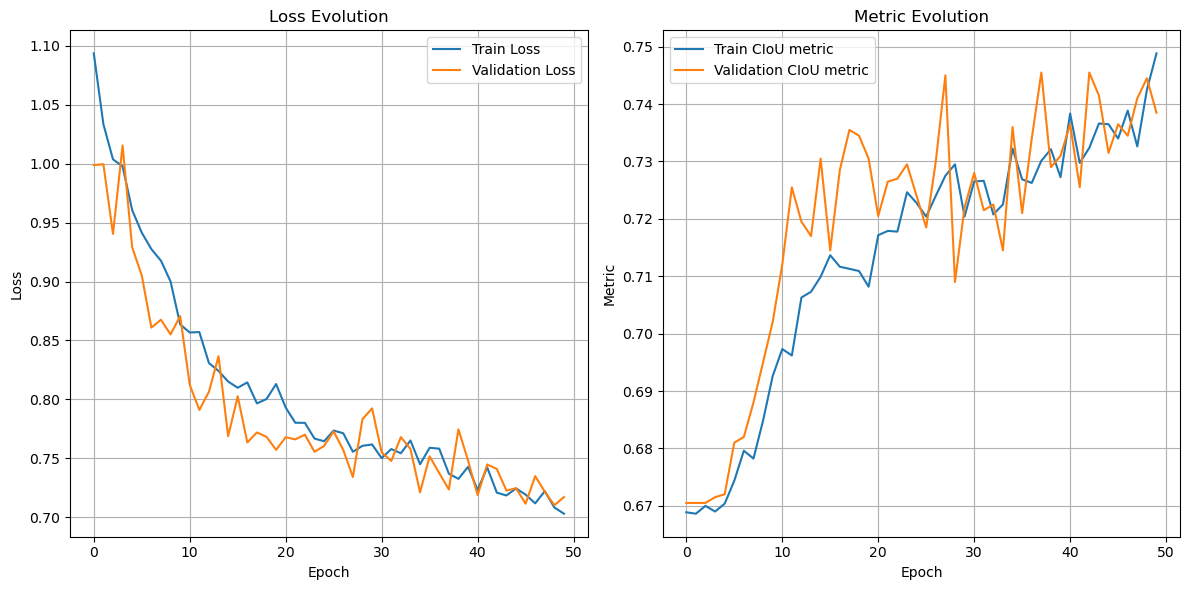

In [19]:
plot_history(history1, metric_key='accuracy', val_metric_key='val_accuracy')

In [5]:
def get_simplest_model2() -> keras.Model:
    def get_attention_module(prev: keras.layers.Layer) -> keras.layers.Layer:
        gap_layer = keras.layers.GlobalAveragePooling2D()(prev)
        gap_layer_res = keras.layers.Reshape((1, 1, 256))(gap_layer)
        dense = keras.layers.Dense(256, activation='relu')(gap_layer_res)
        dense = keras.layers.Dense(256, activation='softmax')(dense)
        mul_layer = keras.layers.Multiply()([prev, dense])

        return mul_layer

    def get_conv_module(
            prev: keras.layers.Layer,
            filters: int,
            drop_rate: float,
            kernel_size: int) -> keras.layers.Layer:
        module = keras.layers.Conv2D(filters, kernel_size, strides=2, activation='relu', padding='same')(prev)
        module = keras.layers.BatchNormalization()(module)
        module = keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(module)
        module = keras.layers.BatchNormalization()(module)
        module = keras.layers.MaxPool2D(pool_size=2)(module)
        module = keras.layers.Dropout(drop_rate)(module)

        return module

    def get_classifier_module(prev: keras.layers.Layer) -> keras.layers.Layer:
        classifier = keras.layers.Flatten()(prev)
        classifier = keras.layers.Dense(512, activation='relu')(classifier)
        classifier = keras.layers.BatchNormalization()(classifier)
        classifier = keras.layers.Dropout(.5)(classifier)

        return classifier

    _input = keras.layers.Input(shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))
    conv = get_conv_module(_input, 64, .25, 3)
    conv = get_conv_module(conv, 128, .4, 3)
    conv = get_conv_module(conv, 256, .5, 3)
    attention1 = get_attention_module(conv)
    attention2 = get_attention_module(conv)
    merged_attentions = keras.layers.concatenate([attention1, attention2])
    classifier = get_classifier_module(merged_attentions)
    output = keras.layers.Dense(num_classes, activation='softmax', name='root')(classifier)
    gap_attention1 = keras.layers.GlobalAveragePooling2D()(attention1)
    gap_attention2 = keras.layers.GlobalAveragePooling2D()(attention2)
    aux_output = keras.layers.Dot(axes=1, normalize=True, name='dot')([gap_attention1, gap_attention2])
    model = keras.Model(_input, outputs=[output, aux_output])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    print(model.summary())

    return model

In [ ]:
train_ds_multi_attention = load_and_preprocess_data()

In [ ]:
model = get_simplest_model2()
history2 = model.fit(train_ds, validation_data=valid_ds, epochs=50)

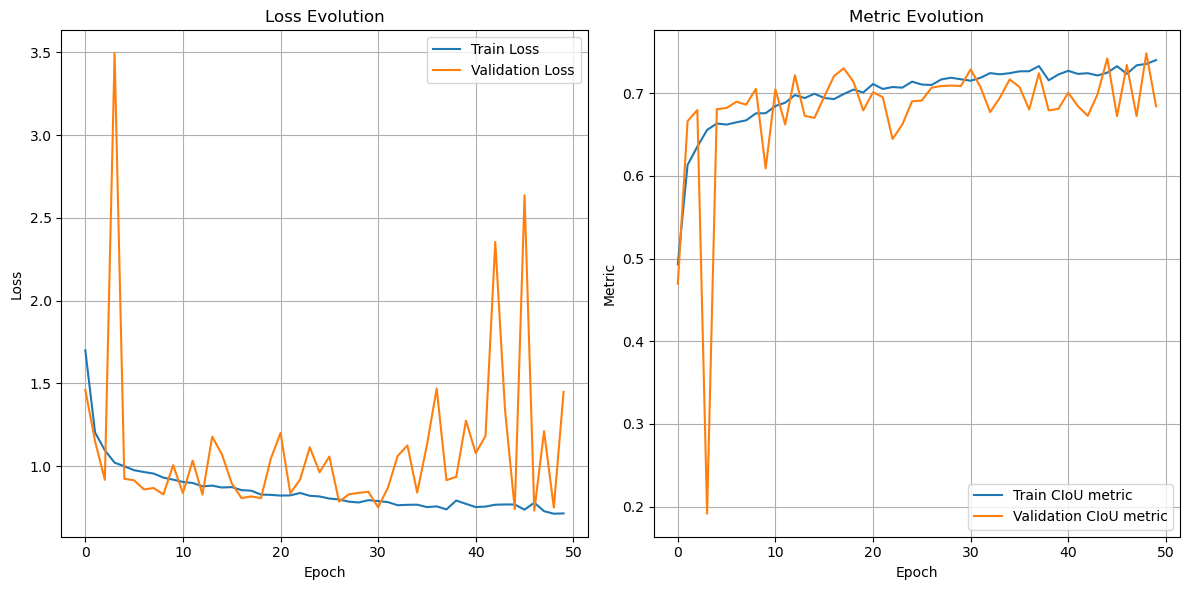

In [11]:
plot_history(history2, metric_key='accuracy', val_metric_key='val_accuracy')